In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Data Description -

In the previous HappyWhale competition, the task was to predict individual humpback whales from images of their flukes. Whales and dolphins in this dataset can be identified by shapes, features and markings (some natural, some acquired) of dorsal fins, backs, heads and flanks. Some species and some individuals have highly distinct features, others are very much less distinct. Further, individual features may change over time. This competition expands that task significantly: data in this competition contains images of over 15,000 unique individual marine mammals from 30 different species collected from 28 different research organizations. Individuals have been manually identified and given an individual_id by marine researches, and your task is to correctly identify these individuals in images. It's a challenging task that has the potential to drive significant advancements in understanding and protecting marine mammals across the globe.

An important note about data quality: Bringing together this dataset from many different research organization posed a number of practical challenges. Significant effort has been made to minimize data quality issues and as well as to minimize leakage as much as possible. There are undoubtably issues. We encourage the community to report these things so that future versions of the data can be improved, but unless there is a significant issue, we don't expect to make updates to the data during the competition.

Files
train_images/ - a folder containing the training images
train.csv - provides the species and the individual_id for each of the training images
test_images/ - a folder containing the test images; for each image, your task is to predict the individual_id; no species information is given for the test data; there are individuals in the test data that are not observed in the training data, which should be predicted as new_individual.
sample_submission.csv - a sample submission file in the correct format

In [2]:
# imports
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
MY_SEP = '-'* 50

Exploratory Data Analysis


In [3]:
# First let's load in the csv files which contains individual id's and labels for the images 
train_df = pd.read_csv('/kaggle/input/happy-whale-and-dolphin/train.csv')
print(f'The number of unique sepcies in the dataset are : {train_df["species"].nunique()}')
print(MY_SEP)
train_df

The number of unique sepcies in the dataset are : 30
--------------------------------------------------


,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...
51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


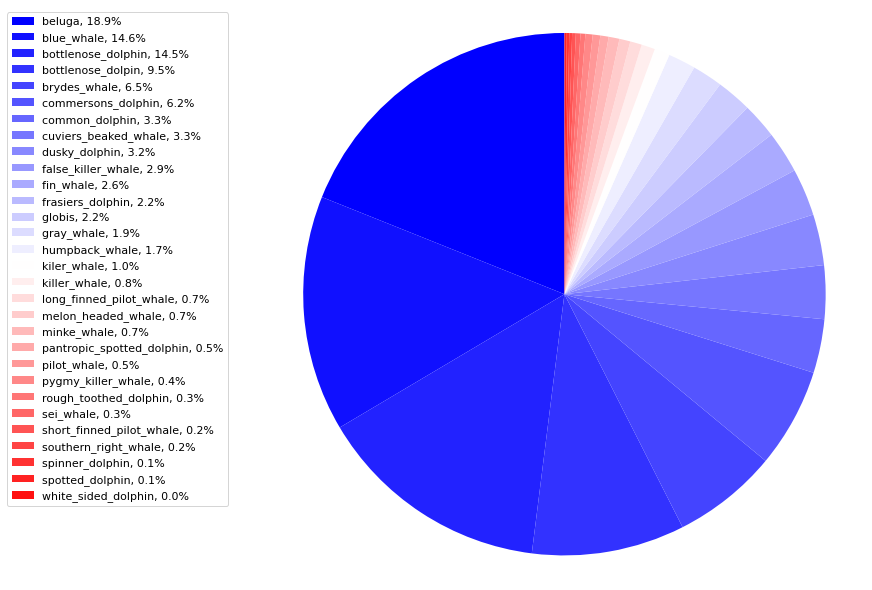

In [4]:
labels = train_df['species'].astype('category').cat.categories.tolist()
counts = train_df['species'].value_counts()
fig1, ax1 = plt.subplots(figsize=(12,8))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(counts)) for i in range(len(counts))])

_, _ = ax1.pie(counts, startangle=90)

ax1.axis('equal')

total = sum(counts)
plt.legend(
    loc='upper left',
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, counts)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

<b><i> Firstly, it can be clearly seen that the distribution between classes is highly unblanaced. The top 4-5 classes cover almost 60% of the training dataset. Also, most classes have a very low number of samples available. <i></b>
    
This would be something to address while training the model. 